# FaceNet Evaluation - Kaggle

Evaluation notebook for FaceNet model using embedding-based verification.

## Approach:
- Extract embeddings for train set (prototypes)
- Extract embeddings for eval set
- Classification using cosine similarity
- Metrics: Top-1/Top-5 accuracy, ROC-AUC, threshold analysis

In [1]:
import os, sys, time, json
import shutil, glob
from datetime import datetime
# numpy và matplotlib sẽ được import sau khi fix compatibility
from tqdm import tqdm
from collections import defaultdict

ROOT = "/kaggle/working/FaceRecognition"
CHECKPOINT_DIR = "/kaggle/working/checkpoints/facenet"
KAGGLE_DATASET_NAME = "celeba-aligned-balanced"
DATA_DIR = f"/kaggle/input/{KAGGLE_DATASET_NAME}"
CHECKPOINT_DATASET_NAME = "facenet-checkpoints"

os.makedirs(CHECKPOINT_DIR, exist_ok=True)

In [2]:
# Copy checkpoint
checkpoint_input = f"/kaggle/input/{CHECKPOINT_DATASET_NAME}"
if os.path.exists(checkpoint_input):
    print(f"Tìm checkpoint trong: {checkpoint_input}")
    pth_files = glob.glob(os.path.join(checkpoint_input, "**/*.pth"), recursive=True)
    print(f"Tìm thấy {len(pth_files)} file .pth")
    
    for pth in pth_files:
        dest = os.path.join(CHECKPOINT_DIR, os.path.basename(pth))
        if not os.path.exists(dest) or os.path.getsize(dest) != os.path.getsize(pth):
            print(f"Copying {os.path.basename(pth)} ({os.path.getsize(pth) / 1024 / 1024:.2f} MB)...")
            shutil.copy(pth, dest)
            # Verify copy
            if os.path.getsize(dest) == os.path.getsize(pth):
                print(f"  [OK] Copied successfully")
            else:
                print(f"  [WARNING] Size mismatch after copy!")
    
    print(f"\nCheckpoints trong {CHECKPOINT_DIR}:")
    for f in os.listdir(CHECKPOINT_DIR):
        size = os.path.getsize(os.path.join(CHECKPOINT_DIR, f))
        print(f"  - {f} ({size / 1024 / 1024:.2f} MB)")
else:
    print(f"[WARNING] Không tìm thấy checkpoint input: {checkpoint_input}")

Tìm checkpoint trong: /kaggle/input/facenet-checkpoints
Tìm thấy 1 file .pth
Copying facenet_best.pth (286.31 MB)...
  [OK] Copied successfully

Checkpoints trong /kaggle/working/checkpoints/facenet:
  - facenet_best.pth (286.31 MB)


In [3]:
# Cau hinh GitHub token
try:
    from kaggle_secrets import UserSecretsClient
    user_secrets = UserSecretsClient()
    GITHUB_TOKEN = user_secrets.get_secret("GITHUB_TOKEN")
    print("[OK] Da lay GITHUB_TOKEN")
except Exception as e:
    GITHUB_TOKEN = None
    print("[INFO] Su dung public URL")

if GITHUB_TOKEN:
    REPO_URL = f"https://{GITHUB_TOKEN}@github.com/sin0235/FaceRecognition.git"
else:
    REPO_URL = "https://github.com/sin0235/FaceRecognition.git"

# Clone repository
if os.path.exists(ROOT):
    print("Repository da ton tai, dang pull updates...")
    %cd {ROOT}
    if GITHUB_TOKEN:
        !git remote set-url origin {REPO_URL}
    !git pull --no-rebase origin fix/lbph-module
else:
    print(f"Dang clone repository...")
    !git clone {REPO_URL} {ROOT}
    %cd {ROOT}

print(f"\nWorking directory: {os.getcwd()}")
!ls -la

# Thêm ROOT vào sys.path để import modules
if ROOT not in sys.path:
    sys.path.insert(0, ROOT)
    print(f"\n[OK] Added {ROOT} to sys.path")

[OK] Da lay GITHUB_TOKEN
Dang clone repository...
Cloning into '/kaggle/working/FaceRecognition'...
remote: Enumerating objects: 1157, done.
remote: Counting objects: 100% (388/388), done.
remote: Compressing objects: 100% (278/278), done.
remote: Total 1157 (delta 223), reused 220 (delta 103), pack-reused 769 (from 1)
Receiving objects: 100% (1157/1157), 6.36 MiB | 23.85 MiB/s, done.
Resolving deltas: 100% (672/672), done.
/kaggle/working/FaceRecognition

Working directory: /kaggle/working/FaceRecognition
total 140
drwxr-xr-x 15 root root  4096 Dec 20 04:01 .
drwxr-xr-x  5 root root  4096 Dec 20 04:00 ..
drwxr-xr-x  2 root root  4096 Dec 20 04:01 app
drwxr-xr-x  2 root root  4096 Dec 20 04:01 configs
drwxr-xr-x  8 root root  4096 Dec 20 04:01 .git
drwxr-xr-x  3 root root  4096 Dec 20 04:01 .github
-rw-r--r--  1 root root  1246 Dec 20 04:01 .gitignore
drwxr-xr-x  2 root root  4096 Dec 20 04:01 inference
-rw-r--r--  1 root root  1075 Dec 20 04:01 LICENSE
drwxr-xr-x  3 root root  4096 De

In [10]:
  !git config --global user.email "phuctoan235@gmail.com"
  !git config --global user.name "sin0235"

In [13]:
# Hủy merge đang dở
!git merge --abort

# Fetch nhánh từ remote
!git fetch origin fix/lbph-module

# Reset local về nhánh remote (xóa toàn bộ thay đổi local)
!git reset --hard origin/fix/lbph-module
!git pull --no-rebase origin fix/lbph-module


From https://github.com/sin0235/FaceRecognition
 * branch            fix/lbph-module -> FETCH_HEAD
HEAD is now at 1bbd38c .
From https://github.com/sin0235/FaceRecognition
 * branch            fix/lbph-module -> FETCH_HEAD
Already up to date.


In [4]:
# # Khởi động lại numpy và matplotlib
# import subprocess
# import sys

# # Cài đặt lại numpy phiên bản tương thích
# subprocess.check_call([sys.executable, "-m", "pip", "install", "--upgrade", "numpy<2.0", "-q"])

# # Sau đó khởi động lại kernel
# import os
# os._exit(0)

In [5]:
# # Cài đặt dependencies với thứ tự đúng để tránh xung đột
# # Thứ tự: numpy -> scipy -> scikit-learn (phụ thuộc numpy/scipy) -> matplotlib/seaborn
# !pip install -q --upgrade numpy
# !pip install -q --upgrade scipy
# !pip install -q --upgrade --force-reinstall scikit-learn
# !pip install -q opencv-python-headless Pillow tqdm pyyaml matplotlib seaborn

In [6]:
# Cài đặt facenet-pytorch (KHÔNG cài lại torch/torchvision)
print("Cài đặt facenet-pytorch...")
!pip install -q facenet-pytorch --no-deps
print("Hoàn tất!")

Cài đặt facenet-pytorch...
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 71.3 MB/s eta 0:00:00
Hoàn tất!


In [7]:
# Import các thư viện cần thiết
import sys

# Import numpy
import numpy as np

# Kiểm tra và import matplotlib, seaborn, sklearn
try:
    import matplotlib.pyplot as plt
    import seaborn as sns
    from sklearn.metrics import confusion_matrix, roc_curve, auc
    from sklearn.preprocessing import label_binarize
    from sklearn.manifold import TSNE
except (ImportError, AttributeError, TypeError, ValueError) as e:
    # Fix compatibility issues với numpy/scipy/matplotlib/sklearn
    print(f"Đang fix compatibility: {e}")
    !pip install -q --upgrade --force-reinstall numpy scipy scikit-learn matplotlib seaborn
    # Xóa các modules để import lại
    modules_to_remove = [k for k in list(sys.modules.keys()) 
                        if any(x in k for x in ['matplotlib', 'seaborn', 'scipy', 'sklearn'])]
    for mod in modules_to_remove:
        del sys.modules[mod]
    import matplotlib.pyplot as plt
    import seaborn as sns
    from sklearn.metrics import confusion_matrix, roc_curve, auc
    from sklearn.preprocessing import label_binarize
    from sklearn.manifold import TSNE

import torch
from PIL import Image

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Device: {device}")

Device: cuda


---
## 1. Load FaceNet Model

In [14]:
from models.facenet.facenet_model import FaceNetModel
from models.facenet.checkpoint_utils import load_facenet_checkpoint_flexible

checkpoint_path = os.path.join(CHECKPOINT_DIR, "facenet_best.pth")

# Validate checkpoint file trước khi load
if not os.path.exists(checkpoint_path):
    raise FileNotFoundError(
        f"Checkpoint không tồn tại: {checkpoint_path}\n"
        f"Vui lòng kiểm tra:"
        f"  1. Dataset checkpoint đã được add vào Kaggle input chưa?"
        f"  2. Tên dataset có đúng '{CHECKPOINT_DATASET_NAME}' không?"
        f"  3. File facenet_best.pth có trong dataset không?"
    )

file_size = os.path.getsize(checkpoint_path)
print(f"Checkpoint file: {checkpoint_path}")
print(f"File size: {file_size / 1024 / 1024:.2f} MB")

if file_size < 1024:
    raise ValueError(f"Checkpoint file quá nhỏ ({file_size} bytes), có thể bị hỏng")

# Initialize model
model = FaceNetModel(embedding_size=128, pretrained=None)

# Load checkpoint với automatic key remapping
try:
    model, ckpt_info = load_facenet_checkpoint_flexible(model, checkpoint_path)
except RuntimeError as e:
    if "zip archive" in str(e) or "central directory" in str(e):
        print(f"\n[ERROR] Checkpoint file bị hỏng!")
        print(f"Vui lòng:")
        print(f"  1. Kiểm tra lại file checkpoint trong dataset")
        print(f"  2. Tải lại checkpoint từ nguồn")
        print(f"  3. Đảm bảo file không bị corrupt khi upload")
    raise
model.to(device).eval()

print(f"Model loaded: embedding_size={128}")
print(f"Training epochs: {ckpt_info['epoch'] + 1}")
print(f"Val triplet acc: {ckpt_info.get('val_triplet_acc', 0):.2f}%")
print(f"Val verification acc: {ckpt_info.get('val_ver_acc', 0):.2f}%")

Checkpoint file: /kaggle/working/checkpoints/facenet/facenet_best.pth
File size: 286.31 MB
[INFO] Loading checkpoint: /kaggle/working/checkpoints/facenet/facenet_best.pth (286.31 MB)
[INFO] Key mismatch detected: checkpoint uses 'model.*' but model uses 'backbone.*'
[OK] Remapped 716 keys
[INFO] Ignored logits layer keys (2): ['backbone.logits.weight', 'backbone.logits.bias']...
[OK] Checkpoint loaded successfully
Model loaded: embedding_size=128
Training epochs: 95
Val triplet acc: 0.00%
Val verification acc: 0.00%


---
## 2. Build Reference Database

In [15]:
from models.facenet.facenet_dataloader import get_val_transforms
from torch.utils.data import DataLoader, Dataset

# Find data dirs
train_dir = os.path.join(DATA_DIR, "CelebA_Aligned_Balanced", "train")
val_dir = os.path.join(DATA_DIR, "CelebA_Aligned_Balanced", "val")
test_dir = os.path.join(DATA_DIR, "CelebA_Aligned_Balanced", "test")

if not os.path.exists(train_dir):
    train_dir = os.path.join(DATA_DIR, "train")
    val_dir = os.path.join(DATA_DIR, "val")
    test_dir = os.path.join(DATA_DIR, "test")

print(f"Train dir: {train_dir}")
print(f"Val dir: {val_dir}")
print(f"Test dir: {test_dir}")

Train dir: /kaggle/input/celeba-aligned-balanced/CelebA_Aligned_Balanced/train
Val dir: /kaggle/input/celeba-aligned-balanced/CelebA_Aligned_Balanced/val
Test dir: /kaggle/input/celeba-aligned-balanced/CelebA_Aligned_Balanced/test


In [16]:
# Simple dataset class
class SimpleDataset(Dataset):
    def __init__(self, data_root, transform, max_per_identity=None):
        self.transform = transform
        self.samples = []  # (path, identity_name)
        
        for identity in sorted(os.listdir(data_root)):
            identity_path = os.path.join(data_root, identity)
            if not os.path.isdir(identity_path): continue
            
            imgs = [f for f in os.listdir(identity_path) if f.lower().endswith(('.jpg', '.png'))]
            if max_per_identity:
                imgs = imgs[:max_per_identity]
            
            for img in imgs:
                self.samples.append((os.path.join(identity_path, img), identity))
    
    def __len__(self): return len(self.samples)
    
    def __getitem__(self, idx):
        path, identity = self.samples[idx]
        img = Image.open(path).convert('RGB')
        if self.transform: img = self.transform(img)
        return img, identity

In [17]:
# Extract train embeddings (prototypes)
transform = get_val_transforms(image_size=160)  # FaceNet uses 160x160
train_dataset = SimpleDataset(train_dir, transform, max_per_identity=5)
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=False, num_workers=4)

print(f"Train samples: {len(train_dataset)}")

# Extract embeddings
identity_embeddings = defaultdict(list)

print("Extracting train embeddings...")
with torch.no_grad():
    for images, identities in tqdm(train_loader):
        images = images.to(device)
        embeddings = model(images)  # [B, 128]
        embeddings = embeddings.cpu().numpy()
        
        for emb, identity in zip(embeddings, identities):
            identity_embeddings[identity].append(emb)

# Compute prototypes (mean embeddings)
prototypes = {}
for identity, embs in identity_embeddings.items():
    mean_emb = np.mean(embs, axis=0)
    mean_emb = mean_emb / np.linalg.norm(mean_emb)  # L2 normalize
    prototypes[identity] = mean_emb

print(f"Built {len(prototypes)} identity prototypes")

Train samples: 46715
Extracting train embeddings...


100%|██████████| 365/365 [01:23<00:00,  4.38it/s]


Built 9343 identity prototypes


In [18]:
# Convert to matrix for fast computation
identity_list = sorted(prototypes.keys())
identity_to_idx = {name: i for i, name in enumerate(identity_list)}
prototype_matrix = np.array([prototypes[name] for name in identity_list])  # [N, 128]

print(f"Prototype matrix: {prototype_matrix.shape}")

Prototype matrix: (9343, 128)


---
## 3. Evaluate with Cosine Similarity

In [19]:
# Load eval dataset
eval_dir = test_dir if os.path.exists(test_dir) else val_dir
eval_dataset = SimpleDataset(eval_dir, transform)
eval_loader = DataLoader(eval_dataset, batch_size=128, shuffle=False, num_workers=4)

print(f"Eval dir: {eval_dir}")
print(f"Eval samples: {len(eval_dataset)}")

Eval dir: /kaggle/input/celeba-aligned-balanced/CelebA_Aligned_Balanced/test
Eval samples: 20387


In [20]:
# Evaluate using cosine similarity
all_true_labels = []
all_pred_labels = []
all_similarities = []

print("Evaluating with cosine similarity...")
with torch.no_grad():
    for images, identities in tqdm(eval_loader):
        images = images.to(device)
        embeddings = model(images).cpu().numpy()  # [B, 128]
        
        # Cosine similarity with all prototypes
        similarities = np.dot(embeddings, prototype_matrix.T)  # [B, N]
        
        # Top-1 predictions
        pred_indices = np.argmax(similarities, axis=1)
        
        for identity, pred_idx, sim_row in zip(identities, pred_indices, similarities):
            true_idx = identity_to_idx.get(identity, -1)
            if true_idx >= 0:
                all_true_labels.append(true_idx)
                all_pred_labels.append(pred_idx)
                # Đảm bảo sim_row là 1D array trước khi append
                sim_row_flat = np.array(sim_row).flatten()
                all_similarities.append(sim_row_flat)

# Kiểm tra số lượng samples TRƯỚC KHI convert
if len(all_true_labels) == 0:
    print("\n[ERROR] Không có samples nào có identity trong train set!")
    print("Nguyên nhân: Tất cả identities trong eval set không có trong train set.")
    print(f"Train set có {len(identity_list)} identities")
    if len(eval_dataset) > 0:
        sample_identities = list(set([i for _, i in eval_dataset.samples[:50]]))
        print(f"Sample eval identities (first 50 unique): {sample_identities[:10]}...")
        overlap = len(set(sample_identities) & set(identity_list))
        print(f"Overlap với train set: {overlap} identities")
    raise ValueError("Không có samples hợp lệ để evaluate")

print(f"\nEvaluation summary:")
print(f"  Total eval samples: {len(eval_dataset)}")
print(f"  Valid samples (có trong train set): {len(all_true_labels)}")

all_true_labels = np.array(all_true_labels)
all_pred_labels = np.array(all_pred_labels)

# Convert all_similarities thành 2D array [N_samples, N_identities]
if len(all_similarities) == 0:
    raise ValueError("Không có similarities nào được tính!")

all_similarities = np.array(all_similarities)

# Đảm bảo all_similarities là 2D array
if all_similarities.ndim == 1:
    # Nếu chỉ có 1 sample, reshape thành [1, N_identities]
    all_similarities = all_similarities.reshape(1, -1)
elif all_similarities.ndim == 0:
    raise ValueError("all_similarities is scalar, không hợp lệ")

print(f"Similarities shape: {all_similarities.shape}")
print(f"Expected: [N_samples={len(all_true_labels)}, N_identities={len(identity_list)}]")

Evaluating with cosine similarity...


100%|██████████| 160/160 [00:43<00:00,  3.70it/s]



Evaluation summary:
  Total eval samples: 20387
  Valid samples (có trong train set): 20387
Similarities shape: (20387, 9343)
Expected: [N_samples=20387, N_identities=9343]


In [21]:
# Compute metrics
if len(all_true_labels) == 0:
    raise ValueError("Không có samples nào để evaluate!")

# Đảm bảo all_similarities là 2D
if all_similarities.ndim == 1:
    all_similarities = all_similarities.reshape(1, -1)

# Top-1 Accuracy
if len(all_pred_labels) > 0 and len(all_true_labels) > 0:
    top1_acc = (all_pred_labels == all_true_labels).mean() * 100
else:
    top1_acc = 0.0

# Top-5 Accuracy
if all_similarities.shape[1] >= 5:
    top5_preds = np.argsort(all_similarities, axis=1)[:, -5:]
    top5_correct = [t in p for t, p in zip(all_true_labels, top5_preds)]
    top5_acc = np.mean(top5_correct) * 100
else:
    # Nếu có ít hơn 5 identities, Top-5 = Top-1
    top5_acc = top1_acc
    print(f"[INFO] Chỉ có {all_similarities.shape[1]} identities, Top-5 = Top-1")

print(f"\n{'='*50}")
print(f"FaceNet EVALUATION RESULTS")
print(f"{'='*50}")
print(f"Total samples: {len(all_true_labels)}")
print(f"Top-1 Accuracy: {top1_acc:.2f}%")
print(f"Top-5 Accuracy: {top5_acc:.2f}%")


FaceNet EVALUATION RESULTS
Total samples: 20387
Top-1 Accuracy: 85.33%
Top-5 Accuracy: 92.79%


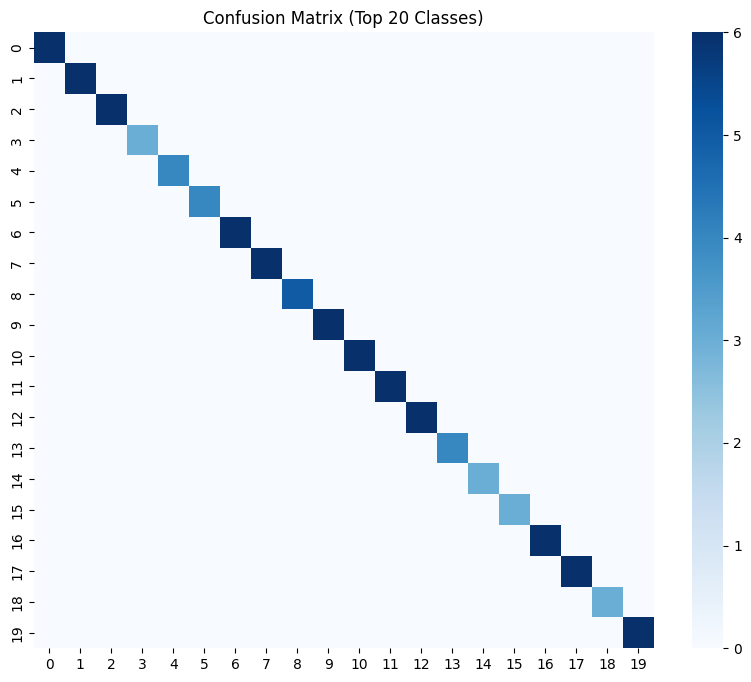

In [22]:
# Confusion Matrix (top 20 classes)
sample_classes = 20
class_counts = np.bincount(all_true_labels, minlength=len(identity_list))
top_classes = np.argsort(class_counts)[-sample_classes:]
mask = np.isin(all_true_labels, top_classes)

labels_sub = all_true_labels[mask]
preds_sub = all_pred_labels[mask]

# Remap
label_map = {old: new for new, old in enumerate(sorted(set(labels_sub)))}
labels_re = np.array([label_map.get(l, -1) for l in labels_sub])
preds_re = np.array([label_map.get(p, -1) for p in preds_sub])
valid = (labels_re >= 0) & (preds_re >= 0)

cm = confusion_matrix(labels_re[valid], preds_re[valid])
plt.figure(figsize=(10, 8))
sns.heatmap(cm, cmap='Blues')
plt.title(f'Confusion Matrix (Top {sample_classes} Classes)')
plt.savefig('/kaggle/working/facenet_confusion_matrix.png', dpi=150)
plt.show()

Computing ROC Curve...


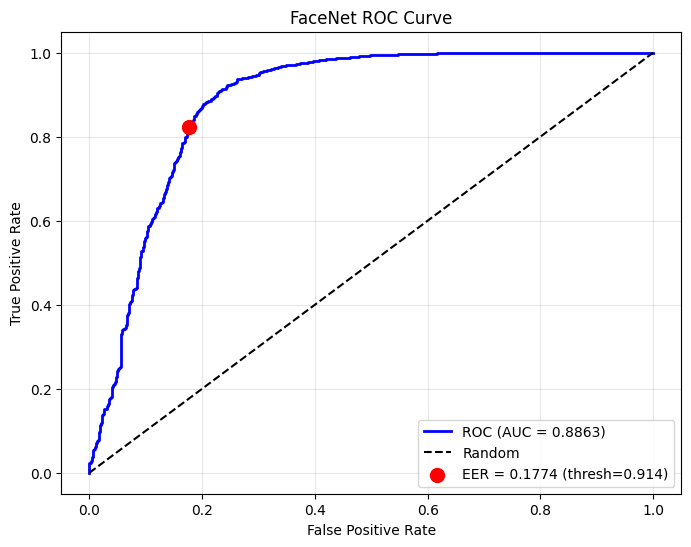

AUC: 0.8863
EER: 0.1774 (threshold: 0.914)


In [23]:
# ROC Curve - Binary classification: correct vs incorrect prediction
print("Computing ROC Curve...")

sample_size = min(5000, len(all_true_labels))
idx = np.random.choice(len(all_true_labels), sample_size, replace=False)
labels_sample = all_true_labels[idx]
sims_sample = all_similarities[idx]

preds_sample = all_pred_labels[idx]

# Binary labels: 1 = correct prediction, 0 = incorrect
y_true_binary = (labels_sample == preds_sample).astype(int)

# Scores: similarity to true class
y_scores = []
for i, true_idx in enumerate(labels_sample):
    y_scores.append(sims_sample[i, true_idx])

y_scores = np.array(y_scores)

fpr, tpr, thresholds = roc_curve(y_true_binary, y_scores)
roc_auc = auc(fpr, tpr)

# EER (Equal Error Rate)
eer_idx = np.argmin(np.abs(fpr - (1 - tpr)))
eer = fpr[eer_idx]
eer_threshold = thresholds[eer_idx]

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC (AUC = {roc_auc:.4f})', color='blue', lw=2)
plt.plot([0, 1], [0, 1], 'k--', label='Random')
plt.scatter([eer], [1-eer], color='red', s=100, zorder=5, 
           label=f'EER = {eer:.4f} (thresh={eer_threshold:.3f})')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('FaceNet ROC Curve')
plt.legend()
plt.grid(True, alpha=0.3)
plt.savefig('/kaggle/working/facenet_roc_curve.png', dpi=150)
plt.show()

print(f"AUC: {roc_auc:.4f}")
print(f"EER: {eer:.4f} (threshold: {eer_threshold:.3f})")

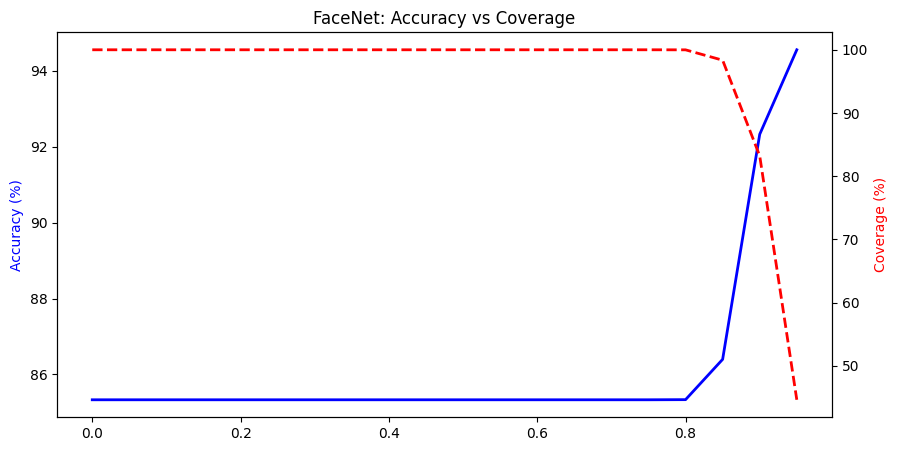

In [24]:
# Threshold Analysis
max_sims = np.max(all_similarities, axis=1)
is_correct = (all_pred_labels == all_true_labels).astype(int)

thresholds = np.arange(0.0, 1.0, 0.05)
accs, covs = [], []
for t in thresholds:
    m = max_sims >= t
    covs.append(m.mean() * 100)
    accs.append(is_correct[m].mean() * 100 if m.sum() > 0 else 0)

fig, ax1 = plt.subplots(figsize=(10, 5))
ax1.plot(thresholds, accs, 'b-', lw=2, label='Accuracy')
ax1.set_ylabel('Accuracy (%)', color='blue')
ax2 = ax1.twinx()
ax2.plot(thresholds, covs, 'r--', lw=2, label='Coverage')
ax2.set_ylabel('Coverage (%)', color='red')
plt.title('FaceNet: Accuracy vs Coverage')
plt.savefig('/kaggle/working/facenet_threshold_analysis.png', dpi=150)
plt.show()

---
## 4. Performance Tests

In [27]:
# Latency Test
dummy = torch.randn(1, 3, 160, 160).to(device)
for _ in range(10): model(dummy)  # Warmup

latencies = []
for _ in range(100):
    if 'cuda' in str(device): torch.cuda.synchronize()
    start = time.time()
    model(torch.randn(1, 3, 160, 160).to(device))
    if 'cuda' in str(device): torch.cuda.synchronize()
    latencies.append((time.time() - start) * 1000)

avg_latency = np.mean(latencies)
print(f"Latency: {avg_latency:.2f} ms (avg)")

Latency: 18.01 ms (avg)


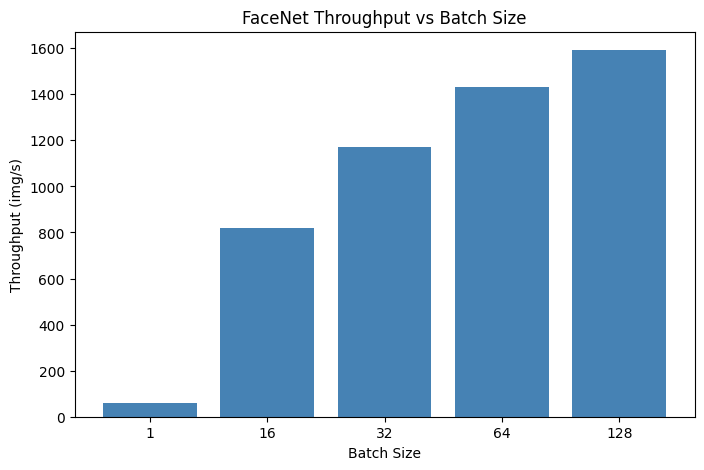

Max Throughput: 1592.03 img/s


In [29]:
# Throughput Test
batch_sizes = [1, 16, 32, 64, 128]
throughputs = []
for bs in batch_sizes:
    dummy = torch.randn(bs, 3, 160, 160).to(device)
    for _ in range(5): model(dummy)  # Warmup
    if 'cuda' in str(device): torch.cuda.synchronize()
    start = time.time()
    for _ in range(20): model(dummy)
    if 'cuda' in str(device): torch.cuda.synchronize()
    throughputs.append((bs * 20) / (time.time() - start))

plt.figure(figsize=(8, 5))
plt.bar([str(b) for b in batch_sizes], throughputs, color='steelblue')
plt.ylabel('Throughput (img/s)')
plt.xlabel('Batch Size')
plt.title('FaceNet Throughput vs Batch Size')
plt.savefig('/kaggle/working/facenet_throughput.png', dpi=150)
plt.show()

max_throughput = max(throughputs)
print(f"Max Throughput: {max_throughput:.2f} img/s")

---
## 5. t-SNE Visualization

 10%|█         | 16/160 [00:03<00:27,  5.29it/s]


t-SNE samples: 208


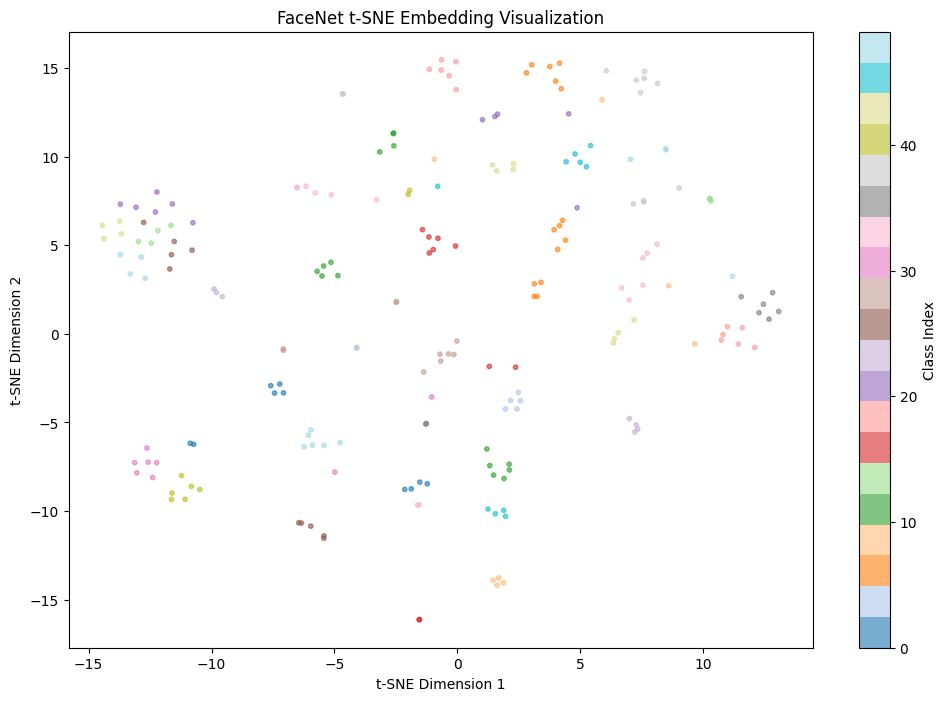

In [30]:
from sklearn.manifold import TSNE

# Extract eval embeddings for t-SNE
emb_list, lbl_list = [], []
with torch.no_grad():
    for img, identity in tqdm(eval_loader):
        if len(emb_list) * 128 >= 2000: break
        emb_list.append(model(img.to(device)).cpu().numpy())
        lbl_list.extend([identity_to_idx.get(i, -1) for i in identity])

embs = np.concatenate(emb_list)[:2000]
lbls = np.array(lbl_list)[:2000]
valid_mask = lbls >= 0
embs, lbls = embs[valid_mask], lbls[valid_mask]

# Top 50 classes
uniq = np.unique(lbls)[:50]
class_mask = np.isin(lbls, uniq)
embs_subset, lbls_subset = embs[class_mask], lbls[class_mask]

print(f"t-SNE samples: {len(embs_subset)}")
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
embs_2d = tsne.fit_transform(embs_subset)

plt.figure(figsize=(12, 8))
plt.scatter(embs_2d[:, 0], embs_2d[:, 1], c=lbls_subset, cmap='tab20', s=10, alpha=0.6)
plt.title('FaceNet t-SNE Embedding Visualization')
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.colorbar(label='Class Index')
plt.savefig('/kaggle/working/facenet_tsne.png', dpi=150)
plt.show()

In [32]:
import pandas as pd
# Export t-SNE data for visualization
tsne_df = pd.DataFrame({
    'x': embs_2d[:, 0].astype(float),
    'y': embs_2d[:, 1].astype(float),
    'label_idx': lbls_subset.astype(int),
})
tsne_df.to_csv('/kaggle/working/facenet_tsne_points.csv', index=False)
print(f'Exported t-SNE points: {len(tsne_df)} samples')

Exported t-SNE points: 208 samples


---
## 6. Final Report

---
## 4. Final Report

In [34]:
report = {
    'timestamp': datetime.now().isoformat(),
    'model': 'FaceNet',
    'method': 'embedding-based (cosine similarity)',
    'embedding_size': 128,
    'metrics': {
        'top1_accuracy': float(top1_acc),
        'top5_accuracy': float(top5_acc),
        'auc': float(roc_auc),
        'eer': float(eer) if 'eer' in globals() else None,
        'eer_threshold': float(eer_threshold) if 'eer_threshold' in globals() else None
    },
    'performance': {
        'avg_latency_ms': float(avg_latency) if 'avg_latency' in globals() else None,
        'max_throughput': float(max_throughput) if 'max_throughput' in globals() else None
    },
    'eval_samples': int(len(all_true_labels)),
    'num_identities': int(len(identity_list))
}

with open('/kaggle/working/facenet_evaluation_report.json', 'w') as f:
    json.dump(report, f, indent=2)

print("\n" + "="*50)
print("FACENET FINAL REPORT")
print("="*50)
print(f"Top-1 Accuracy: {top1_acc:.2f}%")
print(f"Top-5 Accuracy: {top5_acc:.2f}%")
print(f"AUC: {roc_auc:.4f}")
if 'eer' in globals():
    print(f"EER: {eer:.4f} (threshold: {eer_threshold:.3f})")
if 'avg_latency' in globals():
    print(f"Avg Latency: {avg_latency:.2f} ms")
if 'max_throughput' in globals():
    print(f"Max Throughput: {max_throughput:.2f} img/s")
print(f"\nReport saved to: facenet_evaluation_report.json")


FACENET FINAL REPORT
Top-1 Accuracy: 85.33%
Top-5 Accuracy: 92.79%
AUC: 0.8863
EER: 0.1774 (threshold: 0.914)
Avg Latency: 18.01 ms
Max Throughput: 1592.03 img/s

Report saved to: facenet_evaluation_report.json


In [35]:
# Export tất cả mảng và dữ liệu cần thiết cho trực quan hóa
# Cell này có thể chạy độc lập sau khi đã chạy hết notebook

try:
    import pandas as pd
except ImportError:
    !pip install -q pandas
    import pandas as pd

from sklearn.metrics import confusion_matrix

print("="*60)
print("EXPORTING ALL DATA FOR VISUALIZATION")
print("="*60)

# Kiểm tra các biến cần thiết
required_vars = ['all_similarities', 'all_true_labels', 'all_pred_labels', 'identity_list']
missing_vars = [v for v in required_vars if v not in globals()]
if missing_vars:
    raise ValueError(f"Thiếu các biến: {missing_vars}. Vui lòng chạy các cell trước đó!")

print(f"\n[INFO] Data shapes:")
print(f"  - all_similarities: {all_similarities.shape}")
print(f"  - all_true_labels: {all_true_labels.shape}")
print(f"  - all_pred_labels: {all_pred_labels.shape}")
print(f"  - identity_list: {len(identity_list)} identities")

# 1. Export predictions CSV
print("\n[1/4] Exporting predictions CSV...")
predictions_data = {
    'sample_idx': np.arange(len(all_true_labels)),
    'true_label_idx': all_true_labels.tolist(),
    'pred_label_idx': all_pred_labels.tolist(),
    'true_identity': [identity_list[i] for i in all_true_labels],
    'pred_identity': [identity_list[i] for i in all_pred_labels],
    'max_similarity': [all_similarities[i, all_pred_labels[i]] for i in range(len(all_true_labels))],
    'is_correct': (all_true_labels == all_pred_labels).tolist()
}
df_predictions = pd.DataFrame(predictions_data)
df_predictions.to_csv('/kaggle/working/facenet_predictions.csv', index=False)
print(f"  [OK] Exported {len(df_predictions)} samples to facenet_predictions.csv")

# 2. Export confusion matrix CSV (full)
print("\n[2/4] Exporting confusion matrix CSV...")
cm_full = confusion_matrix(all_true_labels, all_pred_labels, labels=np.arange(len(identity_list)))
df_cm = pd.DataFrame(
    cm_full,
    index=[f"{i}_{identity_list[i]}" for i in range(len(identity_list))],
    columns=[f"{i}_{identity_list[i]}" for i in range(len(identity_list))]
)
df_cm.to_csv('/kaggle/working/facenet_confusion_matrix_full.csv')
print(f"  [OK] Exported confusion matrix {cm_full.shape} to facenet_confusion_matrix_full.csv")

# 3. Export similarities matrix CSV (nếu không quá lớn)
print("\n[3/4] Exporting similarities matrix CSV...")
if all_similarities.size < 50000000:  # < 50M elements (~200MB)
    df_similarities = pd.DataFrame(
        all_similarities,
        columns=[f"identity_{i}_{identity_list[i]}" for i in range(len(identity_list))]
    )
    df_similarities.insert(0, 'true_label_idx', all_true_labels)
    df_similarities.insert(1, 'pred_label_idx', all_pred_labels)
    df_similarities.to_csv('/kaggle/working/facenet_similarities_matrix.csv', index=False)
    print(f"  [OK] Exported similarities matrix {all_similarities.shape} to facenet_similarities_matrix.csv")
else:
    print(f"  [SKIP] Similarities matrix quá lớn ({all_similarities.size} elements), bỏ qua CSV")

# 4. Export evaluation data JSON (metadata + labels, KHÔNG lưu similarities vì đã có CSV)
print("\n[4/4] Exporting evaluation data JSON...")
print("  [INFO] Similarities đã được export trong CSV, không lưu vào JSON để giảm kích thước")

evaluation_data = {
    'metadata': {
        'model': 'FaceNet',
        'timestamp': datetime.now().isoformat(),
        'embedding_size': 128,
        'num_identities': len(identity_list),
        'num_samples': len(all_true_labels),
        'similarities_shape': list(all_similarities.shape),
        'note': 'Similarities matrix đã được export trong facenet_similarities_matrix.csv'
    },
    'identity_list': identity_list,
    'true_labels': all_true_labels.tolist(),    # [N_samples]
    'pred_labels': all_pred_labels.tolist(),    # [N_samples]
    'metrics': {}
}

# Không lưu prototype_matrix vào JSON (quá lớn, có thể extract lại từ model nếu cần)
# Chỉ lưu metadata về shape
if 'prototype_matrix' in globals() and prototype_matrix is not None:
    evaluation_data['metadata']['prototype_matrix_shape'] = list(prototype_matrix.shape)
    evaluation_data['metadata']['prototype_matrix_note'] = 'Prototype matrix có thể extract lại từ model'
    print(f"  [INFO] prototype_matrix shape: {prototype_matrix.shape} (không lưu vào JSON)")

# Thêm metrics nếu đã tính
if 'top1_acc' in globals():
    evaluation_data['metrics']['top1_accuracy'] = float(top1_acc)
if 'top5_acc' in globals():
    evaluation_data['metrics']['top5_accuracy'] = float(top5_acc)
if 'roc_auc' in globals():
    evaluation_data['metrics']['auc'] = float(roc_auc)
if 'eer' in globals():
    evaluation_data['metrics']['eer'] = float(eer)
if 'eer_threshold' in globals():
    evaluation_data['metrics']['eer_threshold'] = float(eer_threshold)

with open('/kaggle/working/facenet_evaluation_data.json', 'w') as f:
    json.dump(evaluation_data, f, indent=2)

file_size_mb = os.path.getsize('/kaggle/working/facenet_evaluation_data.json') / (1024 * 1024)
print(f"  [OK] Exported evaluation data JSON ({file_size_mb:.2f} MB)")
print(f"      - Similarities: {all_similarities.shape}")
print(f"      - Labels: {len(all_true_labels)} samples")
print(f"      - Identities: {len(identity_list)}")

print("\n" + "="*60)
print("EXPORT COMPLETED!")
print("="*60)

EXPORTING ALL DATA FOR VISUALIZATION

[INFO] Data shapes:
  - all_similarities: (20387, 9343)
  - all_true_labels: (20387,)
  - all_pred_labels: (20387,)
  - identity_list: 9343 identities

[1/4] Exporting predictions CSV...
  [OK] Exported 20387 samples to facenet_predictions.csv

[2/4] Exporting confusion matrix CSV...
  [OK] Exported confusion matrix (9343, 9343) to facenet_confusion_matrix_full.csv

[3/4] Exporting similarities matrix CSV...
  [SKIP] Similarities matrix quá lớn (190475741 elements), bỏ qua CSV

[4/4] Exporting evaluation data JSON...
  [INFO] Similarities đã được export trong CSV, không lưu vào JSON để giảm kích thước
  [INFO] prototype_matrix shape: (9343, 128) (không lưu vào JSON)
  [OK] Exported evaluation data JSON (0.49 MB)
      - Similarities: (20387, 9343)
      - Labels: 20387 samples
      - Identities: 9343

EXPORT COMPLETED!


In [36]:
# Zip tất cả kết quả để download
import zipfile
from pathlib import Path

output_dir = Path('/kaggle/working')
zip_path = output_dir / 'facenet_evaluation_results.zip'

# Danh sách các file cần zip
files_to_zip = [
    # Reports và metrics
    'facenet_evaluation_report.json',
    'facenet_evaluation_data.json',
    # CSV files
    'facenet_predictions.csv',
    'facenet_confusion_matrix_full.csv',
    'facenet_similarities_matrix.csv',  # Có thể không có nếu quá lớn
    # Visualization plots
    'facenet_confusion_matrix.png',
    'facenet_roc_curve.png',
    'facenet_threshold_analysis.png'
]

# Tạo zip file
added_files = []
with zipfile.ZipFile(zip_path, 'w', zipfile.ZIP_DEFLATED) as zipf:
    for file_name in files_to_zip:
        file_path = output_dir / file_name
        if file_path.exists():
            file_size_mb = file_path.stat().st_size / (1024 * 1024)
            zipf.write(file_path, file_name)
            print(f"[OK] Added {file_name} ({file_size_mb:.2f} MB)")
            added_files.append(file_name)
        else:
            print(f"[WARNING] {file_name} not found, skipping")

# Hiển thị thông tin
if zip_path.exists():
    zip_size_mb = zip_path.stat().st_size / (1024 * 1024)
    print(f"\n{'='*50}")
    print(f"ZIP FILE CREATED: {zip_path.name}")
    print(f"Size: {zip_size_mb:.2f} MB")
    print(f"Files included: {len(added_files)}/{len(files_to_zip)}")
    print(f"{'='*50}")
    print("\nFiles trong zip:")
    for f in added_files:
        print(f"  - {f}")
    print("\nĐể download:")
    print("1. Click vào file 'facenet_evaluation_results.zip' trong panel bên phải")
    print("2. Hoặc chạy: !cp facenet_evaluation_results.zip /kaggle/working/")
else:
    print("[ERROR] Failed to create zip file")

[OK] Added facenet_evaluation_report.json (0.00 MB)
[OK] Added facenet_evaluation_data.json (0.49 MB)
[OK] Added facenet_predictions.csv (0.79 MB)
[OK] Added facenet_confusion_matrix_full.csv (166.67 MB)
[WARNING] facenet_similarities_matrix.csv not found, skipping
[OK] Added facenet_confusion_matrix.png (0.04 MB)
[OK] Added facenet_roc_curve.png (0.06 MB)
[OK] Added facenet_threshold_analysis.png (0.05 MB)

ZIP FILE CREATED: facenet_evaluation_results.zip
Size: 0.75 MB
Files included: 7/8

Files trong zip:
  - facenet_evaluation_report.json
  - facenet_evaluation_data.json
  - facenet_predictions.csv
  - facenet_confusion_matrix_full.csv
  - facenet_confusion_matrix.png
  - facenet_roc_curve.png
  - facenet_threshold_analysis.png

Để download:
1. Click vào file 'facenet_evaluation_results.zip' trong panel bên phải
2. Hoặc chạy: !cp facenet_evaluation_results.zip /kaggle/working/
